<a href="https://colab.research.google.com/github/Constantin-Jehn/DeepLearningLab/blob/main/DLL_Ass4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import math
import time
from tqdm import tqdm

import numpy as np

import torch
from torch import Tensor
import torch.nn as nn

import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [4]:
from torch.utils.data import Dataset


class Vocabulary:

    def __init__(self, pad_token="<pad>", unk_token='<unk>', eos_token='<eos>',
                 sos_token='<sos>'):
        self.id_to_string = {}
        self.string_to_id = {}
        
        # add the default pad token
        self.id_to_string[0] = pad_token
        self.string_to_id[pad_token] = 0
        
        # add the default unknown token
        self.id_to_string[1] = unk_token
        self.string_to_id[unk_token] = 1
        
        # add the default unknown token
        self.id_to_string[2] = eos_token
        self.string_to_id[eos_token] = 2   

        # add the default unknown token
        self.id_to_string[3] = sos_token
        self.string_to_id[sos_token] = 3

        # shortcut access
        self.pad_id = 0
        self.unk_id = 1
        self.eos_id = 2
        self.sos_id = 3

    def __len__(self):
        return len(self.id_to_string)

    def add_new_word(self, string):
        self.string_to_id[string] = len(self.string_to_id)
        self.id_to_string[len(self.id_to_string)] = string

    # Given a string, return ID
    # if extend_vocab is True, add the new word
    def get_idx(self, string, extend_vocab=False):
        if string in self.string_to_id:
            return self.string_to_id[string]
        elif extend_vocab:  # add the new word
            self.add_new_word(string)
            return self.string_to_id[string]
        else:
            return self.unk_id


# Read the raw txt files and generate parallel text dataset:
# self.data[idx][0] is the tensor of source sequence
# self.data[idx][1] is the tensor of target sequence
# See examples in the cell below.
class ParallelTextDataset(Dataset):

    def __init__(self, src_file_path, tgt_file_path, src_vocab=None,
                 tgt_vocab=None, extend_vocab=False, device='cuda'):
        (self.data, self.src_vocab, self.tgt_vocab, self.src_max_seq_length,
         self.tgt_max_seq_length) = self.parallel_text_to_data(
            src_file_path, tgt_file_path, src_vocab, tgt_vocab, extend_vocab,
            device)

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

    def parallel_text_to_data(self, src_file, tgt_file, src_vocab=None,
                              tgt_vocab=None, extend_vocab=False,
                              device='cuda'):
        # Convert paired src/tgt texts into torch.tensor data.
        # All sequences are padded to the length of the longest sequence
        # of the respective file.
        print(src_file)

        assert os.path.exists(src_file)
        assert os.path.exists(tgt_file)

        if src_vocab is None:
            src_vocab = Vocabulary()

        if tgt_vocab is None:
            tgt_vocab = Vocabulary()
        
        data_list = []
        # Check the max length, if needed construct vocab file.
        src_max = 0
        with open(src_file, 'r') as text:
            for line in text:
                tokens = list(line)[:-1]  # remove line break
                length = len(tokens)
                if src_max < length:
                    src_max = length

        tgt_max = 0
        with open(tgt_file, 'r') as text:
            for line in text:
                tokens = list(line)[:-1]
                length = len(tokens)
                if tgt_max < length:
                    tgt_max = length
        tgt_max += 2  # add for begin/end tokens
                    
        src_pad_idx = src_vocab.pad_id
        tgt_pad_idx = tgt_vocab.pad_id

        tgt_eos_idx = tgt_vocab.eos_id
        tgt_sos_idx = tgt_vocab.sos_id

        # Construct data
        src_list = []
        print(f"Loading source file from: {src_file}")
        with open(src_file, 'r') as text:
            for line in tqdm(text):
                seq = []
                tokens = list(line)[:-1]
                for token in tokens:
                    seq.append(src_vocab.get_idx(
                        token, extend_vocab=extend_vocab))
                var_len = len(seq)
                var_seq = torch.tensor(seq, device=device, dtype=torch.int64)
                # padding
                new_seq = var_seq.data.new(src_max).fill_(src_pad_idx)
                new_seq[:var_len] = var_seq
                src_list.append(new_seq)

        tgt_list = []
        print(f"Loading target file from: {tgt_file}")
        with open(tgt_file, 'r') as text:
            for line in tqdm(text):
                seq = []
                tokens = list(line)[:-1]
                # append a start token
                seq.append(tgt_sos_idx)
                for token in tokens:
                    seq.append(tgt_vocab.get_idx(
                        token, extend_vocab=extend_vocab))
                # append an end token
                seq.append(tgt_eos_idx)

                var_len = len(seq)
                var_seq = torch.tensor(seq, device=device, dtype=torch.int64)

                # padding
                new_seq = var_seq.data.new(tgt_max).fill_(tgt_pad_idx)
                new_seq[:var_len] = var_seq
                tgt_list.append(new_seq)

        # src_file and tgt_file are assumed to be aligned.
        assert len(src_list) == len(tgt_list)
        for i in range(len(src_list)):
            data_list.append((src_list[i], tgt_list[i]))

        print("Done.")
            
        return data_list, src_vocab, tgt_vocab, src_max, tgt_max


In [5]:
# `DATASET_DIR` should be modified to the directory where you downloaded
# the dataset. On Colab, use any method you like to access the data
# e.g. upload directly or access from Drive, ...
def load_data():
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  DATASET_DIR = "/content/drive/MyDrive/data"

  TRAIN_FILE_NAME = "train"
  VALID_FILE_NAME = "interpolate"

  INPUTS_FILE_ENDING = ".x"
  TARGETS_FILE_ENDING = ".y"

  TASK = "numbers__place_value"
  # TASK = "comparison__sort"
  # TASK = "algebra__linear_1d"

  # Adapt the paths!

  src_file_path = f"{DATASET_DIR}/{TASK}/{TRAIN_FILE_NAME}{INPUTS_FILE_ENDING}"
  tgt_file_path = f"{DATASET_DIR}/{TASK}/{TRAIN_FILE_NAME}{TARGETS_FILE_ENDING}"

  train_set = ParallelTextDataset(src_file_path, tgt_file_path, extend_vocab=True, device = device)

  # get the vocab
  src_vocab = train_set.src_vocab
  tgt_vocab = train_set.tgt_vocab

  src_file_path = f"{DATASET_DIR}/{TASK}/{VALID_FILE_NAME}{INPUTS_FILE_ENDING}"
  tgt_file_path = f"{DATASET_DIR}/{TASK}/{VALID_FILE_NAME}{TARGETS_FILE_ENDING}"

  valid_set = ParallelTextDataset(
      src_file_path, tgt_file_path, src_vocab=src_vocab, tgt_vocab=tgt_vocab,
      extend_vocab=False, device = device)
  return src_vocab, tgt_vocab, train_set, valid_set

In [6]:
def statistics(train_set, valid_set):
  num_sent_train = len(train_set)
  num_sent_val = len(valid_set)
  print(f'Number of sentences in the trainin set: {num_sent_train}')
  print(f'Number of sentences in the validation set: {num_sent_val}')
  tot_q_char = 0
  tot_a_char = 0
  for i in range(0,num_sent_train):
    tot_q_char += len(train_set[i][0])
    tot_a_char += len(train_set[i][1])

  mean_q = tot_q_char / num_sent_train
  mean_a = tot_a_char / num_sent_train
  print(f'Training: Number of characters: {tot_q_char + tot_a_char}')
  print(f'Training: Average Question length: {mean_q}')
  print(f'Training: Average Answer length:{mean_a}')

  tot_q_char = 0
  tot_a_char = 0

  for i in range(0,num_sent_val):
    tot_q_char += len(valid_set[i][0])
    tot_a_char += len(valid_set[i][1])

  mean_q = tot_q_char / num_sent_val
  mean_a = tot_a_char / num_sent_val

  print(f'Validation: Number of characters: {tot_q_char + tot_a_char}')
  print(f'Validation: Average Question length: {mean_q}')
  print(f'Validation: Average Answer length:{mean_a}')

In [7]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.0, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.max_len = max_len

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)  # shape (max_len, 1, dim)
        self.register_buffer('pe', pe)  # Will not be trained.

    def forward(self, x):
        """Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        assert x.size(0) < self.max_len, (
            "Too long sequence length: increase `max_len` of pos encoding")
        # shape of x (len, B, dim)
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [20]:
class TransformerModel(nn.Module):

    def __init__(self, src_vocab_len: int, tgt_vocab_len: int, d_model: int, n_head: int, dim_feedforward: int, 
                 n_enc_layers: int, n_dec_layers: int, tgt_len:int = 3,  pad_id: int = 0, device = 'cuda:0'):
        super(TransformerModel, self).__init__()

        self.embedding_src = nn.Embedding(src_vocab_len, d_model)
        self.embedding_tgt = nn.Embedding(tgt_vocab_len, d_model)


        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model, n_head, dim_feedforward, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, n_enc_layers)

        decoder_layer = nn.TransformerDecoderLayer(d_model, n_head, dim_feedforward, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, n_dec_layers)

        self.linear = nn.Linear(d_model, tgt_vocab_len)

        self.pad_id = pad_id
        self.device = device
        
        
    def gen_attention_mask(self, inp_len:int) -> Tensor:
        # returns implemented mask for target 
        #taken from https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html
        return torch.triu(torch.full((inp_len, inp_len), float('-inf')), diagonal=1)
    
    def gen_key_pad(self, inp) -> Tensor:
        #expected shape: N,src_len
        #return boolean mask, which is true whenever the pad_id is present
        mask = torch.zeros_like(inp, dtype = torch.bool)
        mask[inp == self.pad_id] = True
        return mask
    
    def encoding(self, src):
         N, src_len = src.shape
         #generate padding mask
         src_key_padding_mask = self.gen_key_pad(src)
         src_key_padding_mask = src_key_padding_mask.to(self.device)
         #do forward:
         src = self.embedding_src(src)
         #bec of batch-first
         src = src.permute(1,0,2)
         src = self.pos_encoder(src)
          #bec of batch-first
         src = src.permute(1,0,2)
          # actual encoding
         memory = self.encoder(src,src_key_padding_mask=src_key_padding_mask)
         #save src_key_padding_mask for memory_key_padding mask
         self.src_key_padding_mask = src_key_padding_mask
         
         return memory
    
    def decoding(self, tgt, memory):
        N, tgt_len = tgt.shape
        #generate attention mask
        tgt_mask = self.gen_attention_mask(tgt_len)
        tgt_mask = tgt_mask.to(self.device)
        #generate padding mask
        tgt_key_padding_mask = self.gen_key_pad(tgt).to(self.device)
        memory_key_padding_mask = self.src_key_padding_mask.to(self.device)
        #start forwarding
        tgt = self.embedding_tgt(tgt)
        #because of batch-first option
        tgt = tgt.permute(1,0,2)
        tgt = self.pos_encoder(tgt)
        #bec. of batch-first
        tgt = tgt.permute(1,0,2)
        #actual decoding
        decoded = self.decoder(tgt, memory, tgt_mask = tgt_mask, 
                                                    tgt_key_padding_mask=tgt_key_padding_mask,
                                                    memory_key_padding_mask= memory_key_padding_mask)
        #classification layer
        output = self.linear(decoded)
        return output
        
        
    def forward(self,src:Tensor=None, tgt:Tensor=None) -> Tensor:
      memory = self.encoding(src)
      #decoding includes classification layer
      output = self.decoding(tgt,memory)
      return output

    def greedy_decoding(self, src, tgt_len, eos_id, sos_id, batch_size):
        #do the encdoding and save the hidden state
        memory = self.encoding(src)
        #fill first column start start of sequence id sos
        tgt = torch.ones(batch_size,1,dtype=torch.int32) * sos_id
        tgt = tgt.to(self.device)

        #initialize boolean values and mask for stopping criteria of the search
        mask = torch.zeros(batch_size,dtype = torch.bool)
        mask = mask.to(self.device)
        eos = False
        completions = 1

        while (not eos) and (completions < tgt_len):
            output = self.decoding(tgt, memory)
            #only extract the last "row" of the sequence to complete
            output = output[:,-1,:]

            soft = F.softmax(output, dim = -1)
            most_prob_char = torch.topk(soft,1,dim=1).indices

            tgt = torch.cat((tgt,most_prob_char), dim = 1)

            #check if last sequence was eos_symbol
            lines_eos = tgt[:,-2] == eos_id
            # or the eos symbol was already in the sequence
            mask = torch.logical_or(lines_eos, mask)
            #fill these entries with padding

            tgt[mask,-1] = self.pad_id
            #increase completions for stopping criteria
            completions += 1
            #if all the last entries had eos symbol
            eos = torch.sum(mask) == batch_size
        return tgt
    
    def accuracy(self, prediction, tgt):
        batch_size ,tgt_len = tgt.shape
        result = torch.sum(prediction == tgt,1) == tgt_len
        n_correct = torch.sum(result).item()
        accuracy = n_correct/batch_size
        return accuracy
        

In [9]:
class Trainer():
    def __init__(self, model:TransformerModel, optimizer, vocab, eos_id, sos_id, pad_id, device):
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss(ignore_index = pad_id)
        self.optimizer = optimizer
        self.vocab = vocab
        self.eos_id = eos_id
        self.sos_id = sos_id
        self.device = device
        #reporting arrays
        self.val_loss = []
        self.val_acc = []
        self.train_loss = []
        self.train_acc = []
    def train(self, train_loader, valid_loader, lr, epochs, n_accumulate, n_reporting = 500):

        for epoch in range(0,epochs):
            self.optimizer.zero_grad()
            running_loss = 0
            accumulated_loss = 0
            
            for it, batch in enumerate(train_loader):
                if it > 21000:
                  break
                self.model.train()
                #load source and target
                src = batch[0]
                tgt = batch[1]
                #put to device
                src = src.to(self.device)
                tgt = tgt.to(self.device)
                batch_size, tgt_len = tgt.shape
                
                #define input and reference for loss
                tgt_in = tgt[:,:-1]
                tgt_ref = tgt[:,1:]

                output = self.model(src = src, tgt = tgt_in)

                #in CrossEntropy the second entry needs to be the class
                output = torch.squeeze(torch.permute(output,(0,2,1)))

                loss = self.loss_fn(output, tgt_ref)

                loss.backward()
                running_loss += loss

                #only update parameters every n-accumulate steps --> increase effective batchsize
                if (it%n_accumulate) == 0:
                    torch.nn.utils.clip_grad_norm(self.model.parameters(), 0.1)
                    self.optimizer.step()
                    self.optimizer.zero_grad()
                    self.model.train()
                    
                if (it%n_reporting) == 0 and it >0 :
                    self.model.eval()
                    print(f'Epoch: {epoch} Iteration {it}:')
                    print(f'Training loss: {running_loss/n_reporting}')
                    self.train_loss.append(running_loss/n_reporting)

                    train_pred = self.model.greedy_decoding(src, tgt_len, self.eos_id, self.sos_id, batch_size)
                    train_pred = train_pred.to(self.device)
                    train_acc = self.model.accuracy(train_pred, tgt)
                    self.train_acc.append(train_acc)
                    print(f'Training accuracy: {train_acc}')
                    running_loss = 0                   

                    val_loss, val_acc = self.validation(valid_loader)
                    print(f'Validation loss: {val_loss}')
                    print(f'Validation accuracy: {val_acc}')

    def validation(self, valid_loader):
      #same procedure as for test data set
        with torch.no_grad():
          running_loss = 0
          running_acc = 0
          for it, batch in enumerate(valid_loader):
            src = batch[0].to(self.device)
            tgt = batch[1].to(self.device)
            batch_size, tgt_len = tgt.shape

            tgt_in = tgt[:,:-1]
            tgt_ref = tgt[:,1:]

            output = self.model(src = src, tgt = tgt_in)
            output = torch.squeeze(torch.permute(output,(0,2,1)))
            loss = self.loss_fn(output, tgt_ref)
            running_loss += loss
            val_pred = self.model.greedy_decoding(src,tgt_len, self.eos_id, self.sos_id, batch_size)
            val_acc = self.model.accuracy(val_pred, tgt)
            running_acc += val_acc
          val_loss = running_loss/it
          val_acc = running_acc/it
          self.val_loss.append(val_loss)
          self.val_acc.append(val_acc)
          return val_loss, val_acc
                    

In [10]:
def create_Datasets():
    src_vocab, tgt_vocab, train_set, valid_set = load_data()
    batch_size = 64
    train_data_loader = DataLoader(
        dataset=train_set, batch_size=batch_size, shuffle=True)
    
    valid_data_loader = DataLoader(
        dataset=valid_set, batch_size=batch_size, shuffle=False)
    return src_vocab, tgt_vocab, train_data_loader, valid_data_loader

In [11]:
def print_example_data(train_data_loader, src_vocab, tgt_vocab):
    batch = next(iter(train_data_loader))
    source = batch[0]
    print(source.shape)
    target=batch[1]
    print(target.shape)
    
    example_source_sequence = []
    
    for i in source[0]:
        example_source_sequence.append(src_vocab.id_to_string[i.item()])
    
    print(example_source_sequence)
    
    print(''.join(example_source_sequence))
    
    example_target_sequence = []
    for i in target[0]:
        example_target_sequence.append(tgt_vocab.id_to_string[i.item()])
    print(example_target_sequence)

In [12]:
def training_curves(train_loss, train_acc, val_loss, val_acc,  title):
  train_loss = np.array(trainer.train_loss)
  train_acc = np.array(trainer.train_acc)
  val_acc = np.array(trainer.val_acc)
  val_loss = np.array(trainer.val_loss)

  n = len(train_loss)
  x = np.arange(0,n,1) * 500
  fig, (ax1,ax2) = plt.subplots(2,1)
  ax1.plot(x, train_loss, label ='training')
  ax1.plot(x, val_loss, label = 'validation')
  #ax1.set_xlabel('iteration')
  ax1.set_ylabel('loss', fontsize = 12)
  ax1.grid(True)
  ax1.set_title(title, fontsize = 12)
  ax1.legend(fontsize=10)

  ax2.plot(x,train_acc, label = 'training')
  ax2.plot(x,val_acc, label ='validation')
  ax2.set_xlabel('iteration', fontsize = 12)
  ax2.set_ylabel('accuracy', fontsize = 12)
  ax2.grid(True)

  fig_to = "/content/drive/MyDrive/data/figures/" + title + '.png'
  plt.savefig(fig_to)
  plt.show()

In [13]:
def example_questions(valid_data_loader, model):
  #check the model on three validation questions
  batch = next(iter(valid_data_loader))
  source = batch[0].to(device)

  prediction = model.greedy_decoding(source, 3, eos_id, sos_id, batch_size)
  for index in [3, 12, 60]:
    question = []
    for i in source[index]:
        question.append(src_vocab.id_to_string[i.item()])
    print_q = ''.join(question)
    print(f'Validation Questions: {print_q}')

    answer = []
    for i in prediction[index]:
      answer.append(tgt_vocab.id_to_string[i.item()])
    print_a = ''.join(answer)
    print(f'Answer: {print_a}')


In [ ]:
src_vocab, tgt_vocab, train_data_loader, valid_data_loader = create_Datasets()
print_example_data(train_data_loader, src_vocab, tgt_vocab)

In [15]:
src_vocab_len = 33
tgt_vocab_len = 14

pad_id = 0
unk_id = 1
eos_id = 2
sos_id = 3
batch_size = 64

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
#default parameters
d_model = 256
n_head = 8
dim_feedforward = 1024
n_enc_layers = 3
n_dec_layers = 2
lr = 0.0001

model = TransformerModel(src_vocab_len, tgt_vocab_len, d_model, n_head, dim_feedforward, n_enc_layers, n_dec_layers, device = device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
n_reporting = 500
trainer = Trainer(model,optimizer,src_vocab,eos_id,sos_id,pad_id, device)

In [18]:
#reduce number of hidden layer d_model to 128
d_model = 128
n_head = 8
dim_feedforward = 1024
n_enc_layers = 3
n_dec_layers = 2
lr = 0.0001

model = TransformerModel(src_vocab_len, tgt_vocab_len, d_model, n_head, dim_feedforward, n_enc_layers, n_dec_layers, device = device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
n_reporting = 500
trainer = Trainer(model,optimizer,src_vocab,eos_id,sos_id,pad_id, device)

In [21]:
#reduce number of hidden layer d_model to 128 and feed-forward to 512
d_model = 128
n_head = 8
dim_feedforward = 512
n_enc_layers = 3
n_dec_layers = 2
lr = 0.0001

model = TransformerModel(src_vocab_len, tgt_vocab_len, d_model, n_head, dim_feedforward, n_enc_layers, n_dec_layers, device = device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
n_reporting = 500
trainer = Trainer(model,optimizer,src_vocab,eos_id,sos_id,pad_id, device)

In [26]:
#reduce number of hidden layer d_model to 128 and increase lr
d_model = 128
n_head = 8
dim_feedforward = 1024
n_enc_layers = 3
n_dec_layers = 2
lr = 0.0005

model = TransformerModel(src_vocab_len, tgt_vocab_len, d_model, n_head, dim_feedforward, n_enc_layers, n_dec_layers, device = device)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
n_reporting = 500
trainer = Trainer(model,optimizer,src_vocab,eos_id,sos_id,pad_id, device)

In [ ]:
epochs = 1
n_accumulate = 10
trainer.train(train_data_loader,valid_data_loader, lr, epochs, n_accumulate, n_reporting = n_reporting)

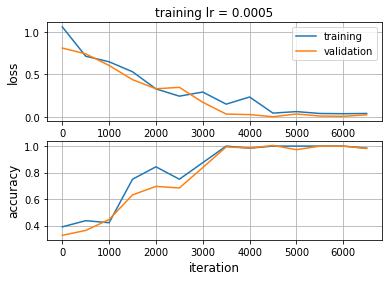

In [29]:
training_curves(trainer.train_loss, trainer.train_acc, trainer.val_loss, trainer.val_acc, 'training lr = 0.0005')

In [ ]:
example_questions(valid_data_loader, trainer.model)